In [1]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, cKDTree
import matplotlib.pyplot as plt
from imageio.v3 import imread

cmap = plt.cm.binary

import config
from create_input_images import data_config
from graph_models import FullGraphModel
from complete_training_data_processing import CompleteModelsDataProcessor
from complete_training_funcs import get_activation_from_cell_type, assign_cell_type
from model_inspection_funcs import process_image, propagate_data_once, compute_voronoi_cells, plot_input_image, plot_voronoi_activations, plot_first_activations


device = torch.device("cpu")
dtype = torch.float32

In [2]:
data_processor = CompleteModelsDataProcessor(
    neurons=config.neurons,
    voronoi_criteria=config.voronoi_criteria,
    random_synapses=config.random_synapses,
    log_transform_weights=config.log_transform_weights,
)

model = FullGraphModel(
    input_shape=data_processor.number_of_synapses,
    num_connectome_passes=config.NUM_CONNECTOME_PASSES,
    decision_making_vector=data_processor.decision_making_vector,
    batch_size=config.batch_size,
    dtype=config.dtype,
    edge_weights=data_processor.synaptic_matrix.data,
    device=config.DEVICE,
    num_classes=len(data_config.CLASSES),
).to(device)

In [3]:
checkpoint = torch.load("models/model_2024-05-17 15:04:25.pth")
model.load_state_dict(checkpoint["model"])
model.eval()
connections = (
    pd.read_csv(
        "adult_data/connections.csv",
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    .groupby(["pre_root_id", "post_root_id"])
    .sum("syn_count")
    .reset_index()
)

connections["weight"] = model.connectome.edge_weight_multiplier.detach()
right_root_ids = data_processor.right_root_ids
all_neurons = pd.read_csv("adult_data/classification_clean.csv").merge(
    right_root_ids, on="root_id"
).fillna("Unknown")
right_visual_neurons = data_processor.voronoi_cells.get_tesselated_neurons().merge(
    right_root_ids, on="root_id"
)
neuron_data = pd.read_csv(
    "adult_data/right_visual_positions_selected_neurons.csv",
    dtype={"root_id": "string"},
).drop(columns=["x", "y", "z", "PC1", "PC2"])
data_cols = ["x_axis", "y_axis"]

In [4]:
# tesselation propagation
centers = neuron_data[neuron_data["cell_type"] == "R7"][data_cols].values
voronoi = Voronoi(centers)
tree = cKDTree(centers)
neuron_indices = tree.query(neuron_data[data_cols].values)[1]
neuron_data["voronoi_indices"] = neuron_indices

In [5]:
img = imread("images/black/train/circle/black_80_31_16.png")
processed_image = process_image(img, tree)
neuron_data = neuron_data.merge(processed_image, left_on="voronoi_indices", right_index=True)
neuron_data["cell_type"] = neuron_data.apply(assign_cell_type, axis=1)
neuron_data["activation"] = neuron_data.apply(get_activation_from_cell_type, axis=1)

In [6]:
def process_and_plot_data(neuron_data, connections, voronoi, num_passes):
    current_data = neuron_data.copy()

    num_columns = 2
    num_rows = (num_passes + 2 + num_columns - 1) // num_columns

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 5))
    axes = axes.flatten() 

    # Initial plot for the input image
    plot_input_image(img, voronoi, axes[0])
    axes[0].set_title('Input Image')

    plot_first_activations(neuron_data.copy(), voronoi, axes[1])
    axes[1].set_title("First activations")

    # Process data and plot activations
    for i in range(num_passes):
        current_data = propagate_data_once(current_data, connections)
        post_synapse_cells = compute_voronoi_cells(current_data, voronoi)
        plot_voronoi_activations(post_synapse_cells, voronoi, ax=axes[i + 2])
        axes[i + 2].set_title(f'Pass {i + 1}')

    # Hide any unused axes if there are any
    for j in range(num_passes + 2, num_rows * num_columns):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

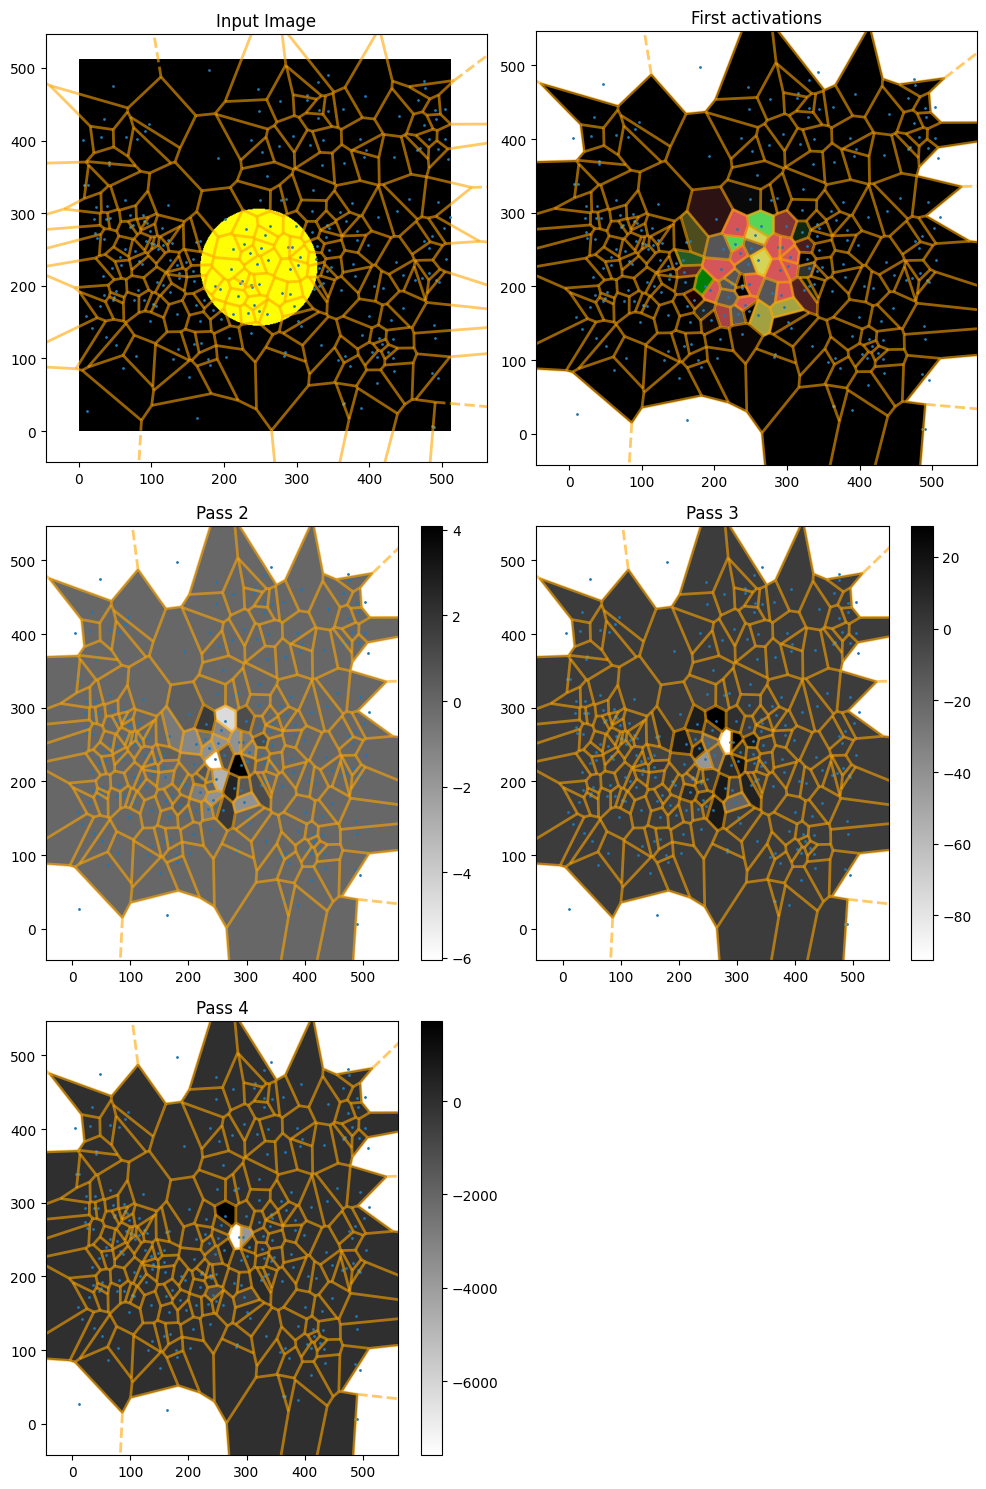

In [7]:
process_and_plot_data(neuron_data, connections, voronoi, 3)